In [33]:
# Import required libraries
import pandas as pd 
import numpy as np 
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from keras.optimizers import Adam

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [47]:
stocks = ['aapl', 'amzn', 'googl', 'msft', 'tsla']

# Create the scaler
scaler = MinMaxScaler()

def dataFrames(stock):

    # Create dataframes for the tweets and prices 
    tweet_df = pd.read_csv('csv/' + stock + '.csv')
    tweet_1_df = pd.read_csv('csv/' + stock + '_1.csv')
    price_df = pd.read_csv('csv/' + stock + '_price.csv')

    # Rename the date column so they match between dataframes
    tweet_df.rename(columns = {'DATE': 'date'}, inplace = True)
    tweet_1_df.rename(columns = {'Date': 'date'}, inplace = True)
    price_df.rename(columns = {'Date' : 'date', 'Close/Last': 'stockPrice'}, inplace = True)

    # Rename the score column so they match between dataframes
    tweet_df.rename(columns = {'TEXTBLOB_POLARITY': 'sentimentScore'}, inplace = True)
    tweet_1_df.rename(columns = {'score': 'sentimentScore'}, inplace = True)

    # Remove the $ sign in stock price, and convert columns to float64 (may be redundant)
    price_df.loc[:, 'stockPrice'] = price_df['stockPrice'].str.replace('$', '')
    tweet_df.loc[:, 'sentimentScore'] = pd.to_numeric(tweet_df['sentimentScore'])
    tweet_1_df.loc[:, 'sentimentScore'] = pd.to_numeric(tweet_1_df['sentimentScore'])
    price_df.loc[:, 'stockPrice'] = pd.to_numeric(price_df['stockPrice'])

    # Convert the dates to pd datetime
    price_df['date'] = pd.to_datetime(price_df['date'])
    tweet_df['date'] = pd.to_datetime(tweet_df['date'], dayfirst = True)
    tweet_1_df['date'] = pd.to_datetime(tweet_1_df['date'])

    # Merge the dataframes based on the date column
    merged_1_df = pd.merge(tweet_df, price_df, on = 'date')
    merged_1_df.to_csv('merged_' + stock + '_1.csv', index = False)
    merged_2_df = pd.merge(tweet_1_df, price_df, on = 'date')
    merged_2_df.to_csv('merged_' + stock + '_2.csv', index = False)
    merged_df = pd.merge(merged_1_df, merged_2_df, how = 'outer')
    merged_df.to_csv('merged_' + stock + '.csv', index = False)

    # TODO: FIX ABOVE MERGING TO HAVE ALL ROWS BEFORE final_df

    '''# Final dataframe with all important variables
    final_df = merged_df[['date', 'sentimentScore_x', 'stockPrice_x']]

    # Rename the columns again
    final_df.rename(columns = {'sentimentScore_x': 'sentimentScore', 'stockPrice_x': 'stockPrice'}, inplace = True)

    # Convert date to specific variables
    final_df['date'] = pd.to_datetime(final_df['date'])
    final_df['year'] = final_df['date'].dt.year
    final_df['month'] = final_df['date'].dt.month
    final_df['day'] = final_df['date'].dt.day
    final_df['day_of_week'] = final_df['date'].dt.dayofweek

    # One-hot encoding, should be done for all for financial data
    final_df = pd.get_dummies(final_df, columns = ['year', 'month', 'day', 'day_of_week'])

    # Drop the original date column
    final_df.drop(columns = ['date'])

    # Save to csv for double checking
    final_df.to_csv('final_' + stock + '.csv', index = False)

    # Split the dataframe into X and y
    X = final_df.drop(columns = ['stockPrice'])
    y = final_df['stockPrice'].values

    print(X)
    print(y)

    X = scaler.fit_transform(X)
    y = scaler.fit_transform(y)

    # Reshape X
    X = X.reshape(-1, 1, 1)
    print(X)'''

for i in stocks:
    dataFrames(i)

In [ ]:
# NOTE: should be deleted and moved to above, with X and y returning 

# Define the variable 'X' before reshaping it
X = final_df['sentimentScore'].values

# Define the variable 'y'
y = final_df['stockPrice'].values

# Reshape X
X = X.reshape(-1, 1, 1)

# Split X and Y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# More reshaping that needs to be fixed
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Define the variable 'final_df' before reshaping X_train
final_df = merged_df[['sentimentScore', 'stockPrice']]

# Define the variable 'X_train' before reshaping it
X_train = final_df['sentimentScore'].values

# Reshape X_train
X_train = X_train.reshape(-1, 1, 1)

# LSTM Model with Dropout and Dense
model = Sequential([
    Input(shape = X_train.shape[1:]),
    LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1:], 1)),
    Dropout(0.2), 
    LSTM(units = 50, return_sequences = True),
    Dropout(0.2),
    LSTM(units = 50),
    Dropout(0.2),
    Dense(units = 1)
])

# Use the Adam optimizer
model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'mean_squared_error')


/Users/ajaffar/opt/miniconda3/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Define and initialize the model
model = Sequential([
    Input(shape = X_train.shape[1:]),
    LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1:], 1)),
    Dropout(0.2), 
    LSTM(units = 50, return_sequences = True),
    Dropout(0.2),
    LSTM(units = 50),
    Dropout(0.2),
    Dense(units = 1)
])

# Convert the data type of input arrays to float32
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')


# Use the Adam optimizer
model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'mean_squared_error')

# Ensure that X_train and y_train have the same number of samples
X_train = X_train[:len(y_train)]

# Fit the model with verbose settings for debugging
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)


# Calculate and print the loss
loss = model.evaluate(X_test, y_test)
print("Test Loss: ", loss)

Epoch 1/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2144
Epoch 2/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0571
Epoch 3/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0548
Epoch 4/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0534
Epoch 5/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0536
Epoch 6/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0543
Epoch 7/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0550
Epoch 8/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0553
Epoch 9/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0534
Epoch 10/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0533
Epoch 11/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0539
Epoch 12/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0542
Epoch 13/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0515
Epoch 14/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0509
Epoch 15/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Reshape X_train and X_test to 2D
num_samples, timesteps, num_features = X_train.shape
X_train_2d = X_train.reshape(num_samples, timesteps * num_features)
X_test_2d = X_test.reshape(X_test.shape[0], timesteps * num_features)

# Define and initialize the RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model with the reshaped 2D training data
rf_model.fit(X_train_2d, y_train)

# Make predictions on the reshaped 2D test data
rf_predictions = rf_model.predict(X_test_2d)

# Calculate and print the loss for the test set predictions
rf_loss = mean_squared_error(y_test, rf_predictions)
print("Random Forest Test Loss: ", rf_loss)

Random Forest Test Loss:  0.05631243075711591


In [ ]:
from sklearn.linear_model import LinearRegression

# Define and initialize the Linear Regression model
lr_model = LinearRegression()

# Fit the model with the reshaped 2D training data
lr_model.fit(X_train_2d, y_train)

# Make predictions on the reshaped 2D test data
lr_predictions = lr_model.predict(X_test_2d)

# Calculate and print the loss for the test set predictions
lr_loss = mean_squared_error(y_test, lr_predictions)
print("Linear Regression Test Loss: ", lr_loss)


Linear Regression Test Loss:  0.053374127


In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Define and initialize the Decision Tree model
dt_model = DecisionTreeRegressor(random_state=42)

# Fit the model with the reshaped 2D training data
dt_model.fit(X_train_2d, y_train)

# Make predictions on the reshaped 2D test data
dt_predictions = dt_model.predict(X_test_2d)

# Calculate and print the loss for the test set predictions
dt_loss = mean_squared_error(y_test, dt_predictions)
print("Decision Tree Test Loss: ", dt_loss)


Decision Tree Test Loss:  0.058767804263896294


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Convert continuous labels to discrete integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define and initialize the Gaussian Naive Bayes model
bayes_model = GaussianNB()

# Fit the model with the reshaped 2D training data and encoded labels
bayes_model.fit(X_train_2d, y_train_encoded)

# Make predictions on the reshaped 2D test data
bayes_predictions = bayes_model.predict(X_test_2d)


# Calculate and print the accuracy for the test set predictions
accuracy = accuracy_score(y_test_encoded, bayes_predictions)
print("Gaussian Naive Bayes Test Accuracy: ", accuracy)


Gaussian Naive Bayes Test Accuracy:  0.21423728813559323


In [ ]:
# Predict the stock prices using the trained model
y_pred = model.predict(X_train)

# Convert the predicted values to binary (0 or 1) based on whether the price goes up or down
y_pred_binary = np.where(y_pred > y_test, 1, 0)

# Print the last 10 predicted binary values
predicted_values = y_pred_binary.flatten()
pred_values = predicted_values[-10:]
print("Predicted values:", pred_values)

newpred_values = np.array(pred_values)



185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step
Predicted values: [1 1 1 1 0 1 1 1 0 0]


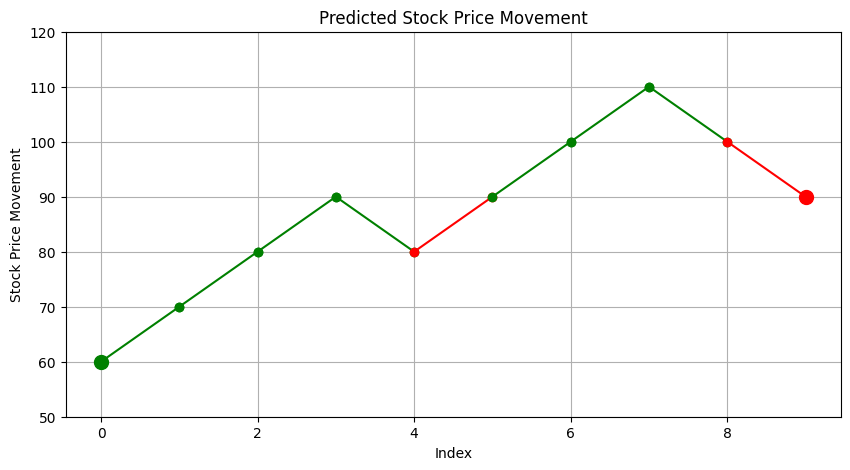

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Start at a base value (e.g., 50) for the y-axis
y_values = [50] 
for change in newpred_values:
    # Increase or decrease the stock price based on the prediction
    y_values.append(y_values[-1] + (10 if change == 1 else -10))

# Remove the starting base value to match the length of newpred_values
y_values.pop(0)

# Now plot the zigzag graph
plt.figure(figsize=(10,5))

# Plot the lines and points
for i in range(1, len(y_values)):
    # Choose color based on the prediction
    color = 'green' if newpred_values[i-1] == 1 else 'red'
    plt.plot([i-1, i], [y_values[i-1], y_values[i]], color=color, marker='o')

# Mark the starting and ending points with larger dots
plt.plot(0, y_values[0], 'go', markersize=10)  # Starting point
plt.plot(len(newpred_values)-1, y_values[-1], 'ro', markersize=10)  # Ending point

# Set labels and title
plt.xlabel('Index')
plt.ylabel('Stock Price Movement')
plt.title('Predicted Stock Price Movement')
plt.grid(True)

# Adjust the y-axis limits for a clear view
plt.ylim(min(y_values) - 10, max(y_values) + 10)

# Display the plot
plt.show()
